In [185]:
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from wordcloud import WordCloud
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from tqdm import tqdm
import scipy.sparse
import pickle

import warnings
warnings.filterwarnings("ignore")

# Loading Raw Train Dataset:

In [3]:
data = pd.read_csv("data/Train.csv", usecols=["Id"])
print("Number of rows in dataset:",data.shape)

Number of rows in dataset: (6034195, 1)


In [4]:
data = pd.read_csv("data/Train.csv", nrows=5)
print("Columns in Train Data:",data.columns)
data.head()

Columns in Train Data: Index(['Id', 'Title', 'Body', 'Tags'], dtype='object')


,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


# Exploratory Data Analysis:

## Preprocessing of Data:

In [ ]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
with open('Train.csv', mode='r', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line=0
    count=1
    for row in tqdm(csv_reader):
        Id, Title, Body, Tags = row["Id"], row["Title"], row["Body"], row["Tags"]
        line+=1
        is_code=0
        code_str=""
        
        if '<code>' in Body:
            is_code = 1
            code = re.findall('<code>(.*?)</code>', Body, flags=re.MULTILINE|re.DOTALL)
            code_str = code_str.join(code)
        
        question=re.sub('<code>(.*?)</code>', '', Body, flags=re.MULTILINE|re.DOTALL)
        
        question=striphtml(question.encode('utf-8'))
        question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
        words=word_tokenize(str(question.lower()))
        question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
        
        Title=striphtml(Title.encode('utf-8'))
        Title=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',Title)
        words=word_tokenize(str(Title.lower()))
        Title=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c' or j=='r'))
        
        
        sent=""
        dup = dict()
        for ch in code_str:
            ch=ch.lower()
            if(ch.isalpha()):
                sent+=(ch)
            if(ch in [' ','.','(',')','{','}','[',']','_','-','/','$','&','<','>',':',';','/','\\',"'",'?','!','@','#','%','^','*','+','=','|']):
                if(ch not in dup):
                    dup[ch]=(int)(1)
                if(dup.get(ch)<=5):
                    dup[ch]=(int)(dup.get(ch)+1)
                    sent+=" "+ch+" "
                else:
                    sent+=" "

        dup = dict()
        sent1=""
        for ch in sent.split():
            if(ch not in dup):
                dup[ch]=(int)(1)
            if(dup.get(ch)<=10):
                dup[ch]=(int)(dup.get(ch)+1)
                sent1+=" "+ch+" "
            else:
                sent1+=" "


        sent1=' '.join(sent1.split())
        
        row_series = pd.Series((Id,Title,question,sent1,is_code,Tags),index=["Id","Title","Question","code","is_code","Tags"])
        preprocessed_data = preprocessed_data.append(row_series, ignore_index = True)
        
        if(line%10000==0):
            preprocessed_data.to_csv("preprocessed/preprocessed_data"+str(count)+".csv")
            preprocessed_data = pd.DataFrame(columns=["Id","Title","Question","code","is_code","Tags"])

preprocessed_data.to_csv("preprocessed/preprocessed_data"+str(count+1)+".csv")
csv_file.close()

In [ ]:
preprocessed_data.to_csv("preprocessed/preprocessed_data604.csv")

### Combining all preprocessed data:

In [ ]:
preprocessed_data_all = pd.read_csv("preprocessed/preprocessed_data1.csv")

In [ ]:
for i in tqdm(range(2,605)):
    preprocessed_data_all = pd.concat([preprocessed_data_all,pd.read_csv("preprocessed/preprocessed_data"+str(i)+".csv")])

In [6]:
preprocessed_data_all.shape

(6034195, 7)

In [ ]:
preprocessed_data_all.to_csv("data/final_preprocessed_data.csv",index=False)

In [7]:
preprocessed_data_all.head()

,Unnamed: 0,Id,Title,Question,code,is_code,Tags
0,0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


## Loading of Pre-Processed Data:

In [5]:
preprocessed_data = pd.read_csv("data/final_preprocessed_data.csv")

## Handling Duplicates:

In [2]:
#preprocessed_data_all = pd.read_csv("data/final_preprocessed_data_no_dup.csv")

In [ ]:
preprocessed_data_all = preprocessed_data[~preprocessed_data.duplicated(["Title","Tags"], keep='first')]

In [5]:
print("Number of duplicate rows :",preprocessed_data.shape[0]-preprocessed_data_all.shape[0])
print("Percent of duplicate rows :",((preprocessed_data.shape[0]-preprocessed_data_all.shape[0])/(preprocessed_data.shape[0]))*100,"%")

Number of duplicate rows : 1848011
Percent of duplicate rows : 44.14547951069518 %


In [6]:
print("Number of rows and columns:",preprocessed_data_all.shape)

Number of rows and columns: (4178926, 6)


In [7]:
preprocessed_data_all.head()

,Id,Title,Question,code,is_code,Tags
0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


## Finding Tags with null values:

In [8]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Tags"].isna()))

Number of rows with null tags: 7


In [9]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Tags"].isna()]

In [10]:
preprocessed_data_all.shape

(4178919, 6)

## Finding Title with null values:

In [11]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Title"].isna()))

Number of rows with null tags: 142


In [12]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Title"].isna()]

In [13]:
preprocessed_data_all.shape

(4178777, 6)

## Finding Question with null values:

In [14]:
print("Number of rows with null tags:",np.sum(preprocessed_data_all["Question"].isna()))

Number of rows with null tags: 2701


In [15]:
preprocessed_data_all = preprocessed_data_all[~preprocessed_data_all["Question"].isna()]

In [16]:
preprocessed_data_all.shape

(4176076, 6)

## EDA on Tags:

In [17]:
tag_count = preprocessed_data_all['Tags'].map(lambda x : (len(x.split())))

In [18]:
pd.value_counts(tag_count)

3    1199093
2    1102709
4     810488
1     561590
5     502196
Name: Tags, dtype: int64

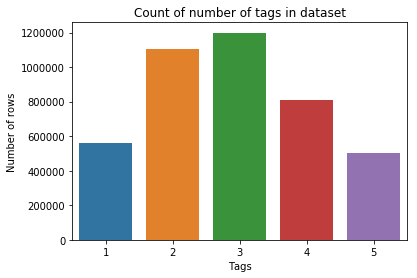

In [19]:
sns.countplot(tag_count)
plt.title("Count of number of tags in dataset")
plt.ylabel("Number of rows")
plt.show()

### Finding frequency of each tag

In [18]:
tag_dict={}

for line in tqdm(preprocessed_data_all["Tags"]):
    for tag in line.split():
        if tag not in tag_dict:
            tag_dict[tag]=1
        else:
            tag_dict[tag]=tag_dict[tag]+1

100%|████████████████████████████████████████████████████████████████████| 4176076/4176076 [00:09<00:00, 441734.55it/s]


#### 20 most occuring tags

In [19]:
from operator import itemgetter
tag_dict_sort = sorted(tag_dict.items(), key = itemgetter(1), reverse = True)
tag_dict_sort[:20]

[('c#', 329491),
 ('java', 297149),
 ('php', 282019),
 ('javascript', 263404),
 ('android', 233301),
 ('jquery', 220039),
 ('c++', 142857),
 ('python', 133064),
 ('iphone', 127797),
 ('asp.net', 124961),
 ('mysql', 121797),
 ('html', 119545),
 ('.net', 113348),
 ('ios', 100476),
 ('objective-c', 95438),
 ('sql', 94606),
 ('css', 93134),
 ('ruby-on-rails', 83054),
 ('linux', 78076),
 ('c', 68616)]

#### 50 most occuring tags in plot

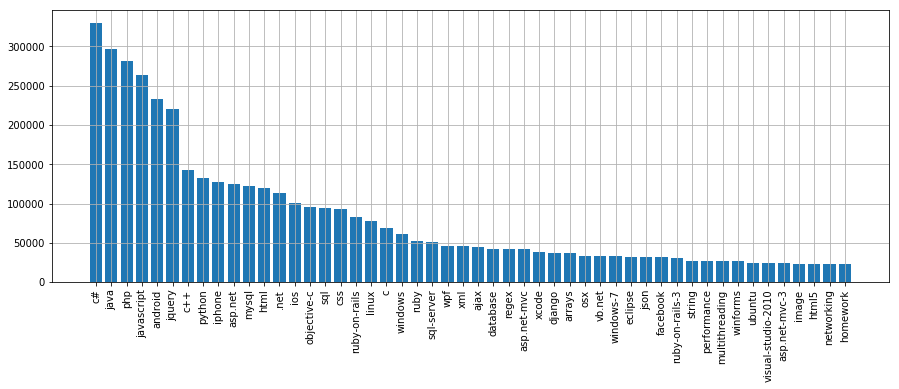

In [20]:
num_tags=[]
name_tags=[]

for x in tag_dict_sort:
    num_tags.append(x[1])
    name_tags.append(x[0])

plt.figure(figsize=(15,5))
plt.bar(range(50), num_tags[:50])
plt.xticks(range(50), name_tags[:50], rotation=90)
plt.grid()
plt.show()

#### we can observe that tags such as : C# , java , php , javascript , android , jquery are most occuring words.

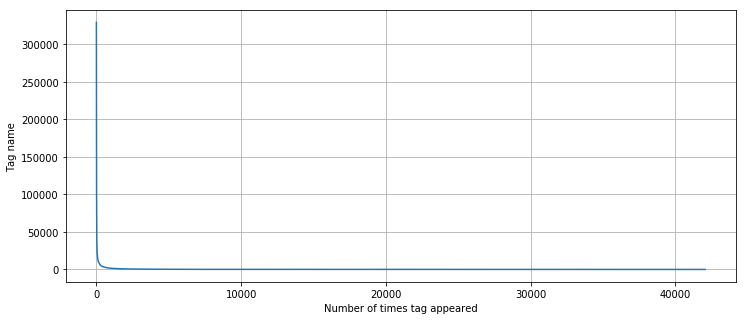

In [23]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(num_tags),1),num_tags)

plt.grid()
plt.ylabel("Tag name")
plt.xlabel("Number of times tag appeared")
plt.show()

## EDA on Title:

In [24]:
title_length=preprocessed_data_all['Title'].map(lambda x : (len(x.split())))

Text(0.5,1,'Title length distribution')

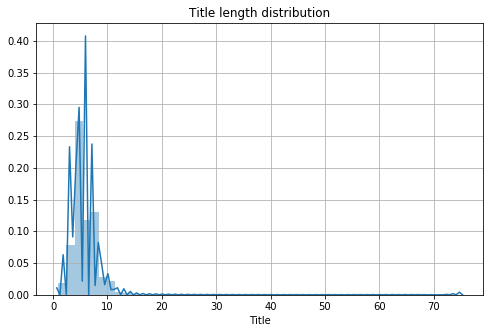

In [25]:
plt.figure(figsize=(8,5))
sns.distplot(title_length)
plt.grid()
plt.title('Title length distribution')

### save final dataset:

In [26]:
preprocessed_data_all.to_csv("final_training_preprocessed.csv",index=False)

In [186]:
preprocessed_data_all = pd.read_csv("data_set/final_training_preprocessed.csv")

## Pre-processing Encoding of tags:

In [187]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data_all['Tags'])

In [188]:
len(vectorizer.get_feature_names())

42048

In [189]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [190]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data_all.shape[0]
for i in tqdm(range(100, total_tags, 100)):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

100%|████████████████████████████████████████████████████████████████████████████████| 420/420 [05:20<00:00,  1.45it/s]


In [191]:
num_tags = []
tags_covered = []

num_tags.append(10)
tags_covered.append((np.round(((total_qs-questions_explained_fn(10))/total_qs)*100,3)))

num_tags.append(50)
tags_covered.append((np.round(((total_qs-questions_explained_fn(50))/total_qs)*100,3)))

In [192]:
i=100
for x in questions_explained:
    num_tags.append(i)
    tags_covered.append(x)
    i+=100

In [194]:
for x,y in zip(num_tags[:20], tags_covered[:20]):
    print(x, y)

10 45.818
50 68.539
100 76.505
200 83.168
300 86.261
400 88.408
500 90.021
600 91.219
700 92.143
800 92.893
900 93.696
1000 94.171
1100 94.558
1200 94.844
1300 95.255
1400 95.54
1500 95.819
1600 96.092
1700 96.317
1800 96.519


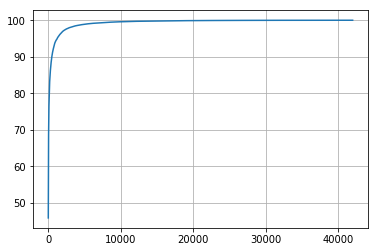

In [195]:
plt.plot(num_tags, tags_covered)
plt.grid()
plt.show()

In [196]:
# we will be taking 100 tags
num_of_tags=100
multilabel_yx = tags_to_choose(num_of_tags)
print("number of questions that are not covered :", questions_explained_fn(num_of_tags),"out of ", total_qs)
print("% of questions that are not covered :", (questions_explained_fn(num_of_tags)/total_qs)*100.0)
print("% of questions that are covered :", 100-(questions_explained_fn(num_of_tags)/total_qs)*100.0)

number of questions that are not covered : 981172 out of  4176076
% of questions that are not covered : 23.49507049201212
% of questions that are covered : 76.50492950798788


In [197]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 42048
number of tags taken : 100 ( 0.2378234398782344 %)


## Masking DataFrame:

In [198]:
tags=[x[0] for x in tag_dict_sort[:100]]

In [199]:
len(tags)

100

In [200]:
count=[]
for i,x in (enumerate(preprocessed_data_all["Tags"])):
    for tag in x.split():
        if(tag in tags):
            count.append(i)
            break

In [201]:
len(count)

3194904

In [202]:
count = count[:100000]

In [203]:
preprocessed_data_all = preprocessed_data_all.iloc[count]

In [204]:
preprocessed_data_all.shape

(100000, 6)

In [205]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data_all['Tags'])

In [206]:
len(vectorizer.get_feature_names())

16200

In [207]:
num_of_tags=100
multilabel_yx = tags_to_choose(num_of_tags)

In [208]:
multilabel_yx

<100000x100 sparse matrix of type '<class 'numpy.int64'>'
	with 157041 stored elements in Compressed Sparse Row format>

### Saving final dataset:

In [209]:
preprocessed_data_all.to_csv("data/final_dataset_train_1L_100_tags.csv",index=False)

In [210]:
scipy.sparse.save_npz('data/class_label_1L_100_tags_sparse_matrix.npz', multilabel_yx)

In [213]:
multilabel_yx = scipy.sparse.load_npz("data/class_label_1L_100_tags_sparse_matrix.npz")

In [214]:
preprocessed_data_all = pd.read_csv("data/final_dataset_train_1L_100_tags.csv")

## Train-Test Split:

In [215]:
train_size=70000

x_train = preprocessed_data_all[:train_size]
x_test = preprocessed_data_all[train_size:]

y_train = multilabel_yx[:train_size]
y_test = multilabel_yx[train_size:]

In [216]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (70000, 100)
Number of data points in test data : (30000, 100)


In [217]:
print("Number of data points in train data :", x_train.shape)
print("Number of data points in test data :", x_test.shape)

Number of data points in train data : (70000, 6)
Number of data points in test data : (30000, 6)


In [218]:
x_train.head()

,Id,Title,Question,code,is_code,Tags
0,1,check upload file imag without mime type,like check upload file imag file e.g png jpg j...,NaN,0,php image-processing file-upload upload mime-t...
1,2,prevent firefox close press ctrl-w,favorit editor vim regular use ctrl-w execut c...,NaN,0,firefox
2,3,r error invalid type list variabl,import matlab file construct data frame matlab...,error in model . frame . default ( formula = e...,1,r matlab machine-learning
3,4,replac special charact url,probabl simpl simpli find answer basicali want...,NaN,0,c# url encoding
4,5,modifi whoi contact detail,use modifi function display warn mesag pleas h...,function modify ( . . . . . ) { $ mcontact = f...,1,php api file-get-contents


# Featurizing data with BoW vectorizer 

In [219]:
train_text = x_train['Title']+" "+x_train['Question']
test_text = x_test['Title']+" "+x_test['Question']

In [220]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [221]:
len(vectorizer.get_feature_names())

10583

## Logistic Regression:

In [222]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:24.252219


In [223]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.29413333333333336
Hamming loss  0.011663666666666666


In [224]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6799, Recall: 0.4869, F1-measure: 0.5674


In [225]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  16.98659956256289


In [226]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

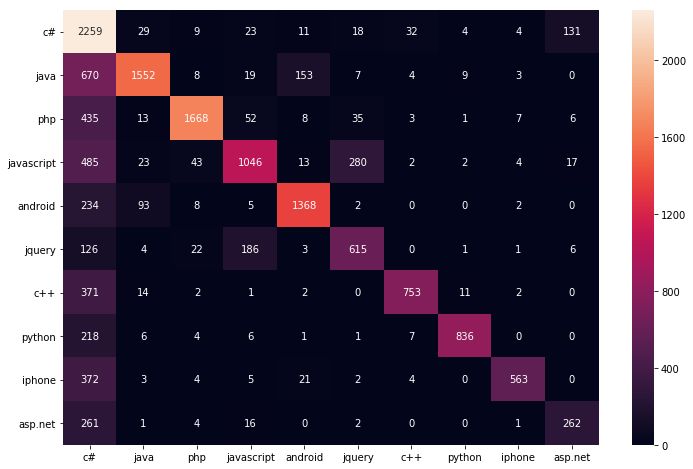

In [227]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model

In [99]:
with open('models/LR_title_question.pkl', 'wb') as f:
    pickle.dump(classifier, f)

## Random Forest

In [229]:
from sklearn.ensemble import RandomForestClassifier

In [230]:
start = datetime.now()
classifier = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:43.006813


In [231]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.195
Hamming loss  0.012655666666666667


In [232]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.8272, Recall: 0.2459, F1-measure: 0.3791


In [104]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  14.365051612818375


In [233]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

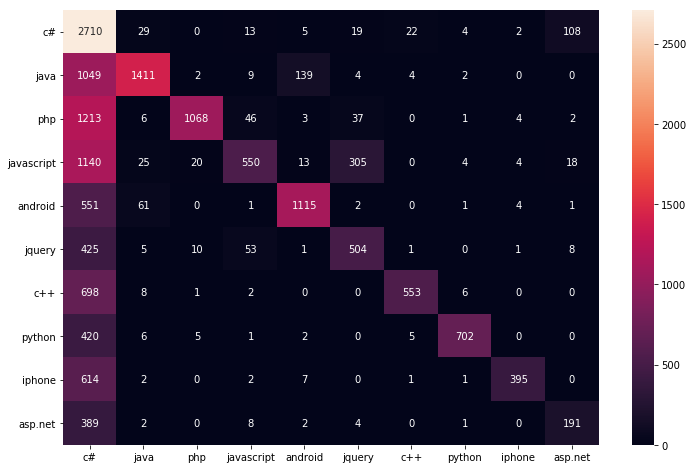

In [234]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

## Model using (3 times repetition of title) + question:

In [235]:
train_text = x_train['Title']+" "+x_train['Title']+" "+x_train['Title']+" "+x_train['Question']
test_text = x_test['Title']+" "+x_test['Title']+" "+x_test['Title']+" "+x_test['Question']

In [236]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [237]:
len(vectorizer.get_feature_names())

10583

In [238]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (70000, 10583) Y : (70000, 100)
Dimensions of test data X: (30000, 10583) Y: (30000, 100)


# Logistic Regression:

In [239]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:21.293704


In [240]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.30593333333333333
Hamming loss  0.011598


In [241]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6749, Recall: 0.5053, F1-measure: 0.5779


In [242]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  17.322222754217513


In [243]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

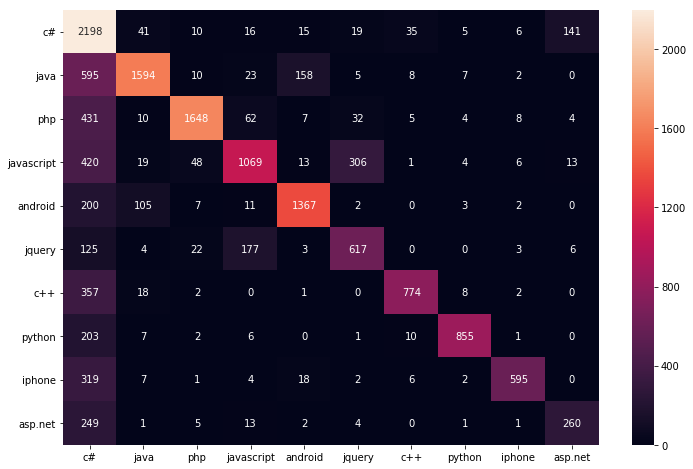

In [244]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

## Random Forest:

In [245]:
start = datetime.now()
classifier = OneVsRestClassifier(RandomForestClassifier(n_jobs=-1))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:50.002062


In [246]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.20873333333333333
Hamming loss  0.012365


In [247]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.8453, Recall: 0.2607, F1-measure: 0.3985


In [248]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  14.199067707428602


In [249]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

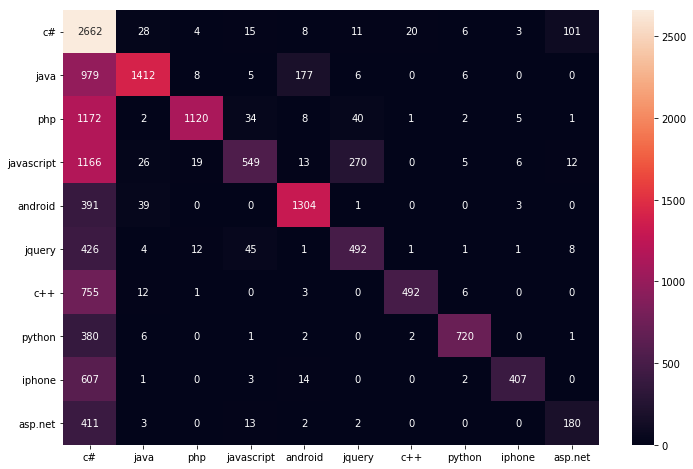

In [250]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

## Model using (3 times repetition of title) + question+code with bag of words representation:

In [251]:
x_train["code"]=x_train["code"].fillna(" ")
x_test["code"]=x_test["code"].fillna(" ")

In [252]:
train_text = x_train['Title']+" "+x_train['Title']+" "+x_train['Title']+" "+x_train['Question']+" "+x_train["code"]
test_text = x_test['Title']+" "+x_test['Title']+" "+x_test['Title']+" "+x_test['Question']+" "+x_test["code"]

In [253]:
vectorizer = CountVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [254]:
len(vectorizer.get_feature_names())

20669

# Logistic Regression:

In [255]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:07:25.908047


In [256]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.3103
Hamming loss  0.011607


In [257]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6591, Recall: 0.5411, F1-measure: 0.5943


In [258]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  17.333186396156883


In [259]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

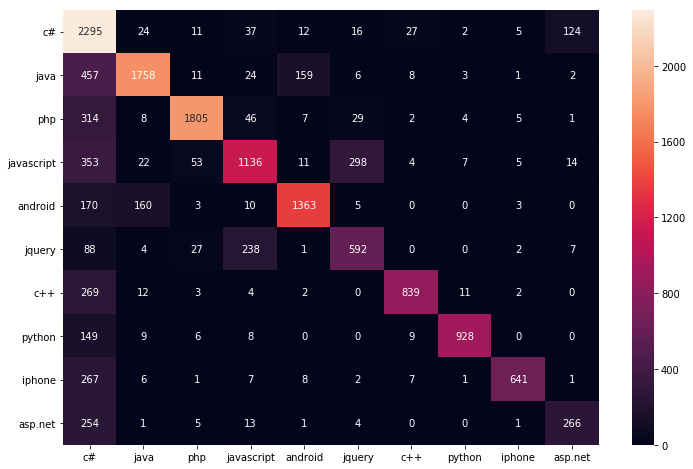

In [260]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model:

In [261]:
tags=[x[0] for x in tag_dict_sort[:100]]

In [262]:
with open('models/tags_list.txt', 'w') as f:
    for item in tags:
        f.write("%s " % item)

## Getting best model by hyperparameter tuning:

## Hyperparameter Tuning Logistic Regression:

In [265]:
for c in [10**-2,10**-1,5*10**-1,1,5,10]:
    classifier = OneVsRestClassifier(LogisticRegression(C=c, penalty='l1'))
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    acc = metrics.accuracy_score(y_test, predictions)
    hl = metrics.hamming_loss(y_test,predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    ll = metrics.log_loss(y_test.todense(), predictions.todense())
    print("C:",c)
    print("Accuracy :",acc,"Hamming loss ",hl,"Log loss : ",ll)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print()

C: 0.01
Accuracy : 0.2665 Hamming loss  0.011159 Log loss :  14.499217238636405
Precision: 0.8063, Recall: 0.3814, F1-measure: 0.5178

C: 0.1
Accuracy : 0.32343333333333335 Hamming loss  0.010359666666666666 Log loss :  15.26503079793445
Precision: 0.7776, Recall: 0.4771, F1-measure: 0.5913

C: 0.5
Accuracy : 0.3262 Hamming loss  0.010874 Log loss :  16.5520758545018
Precision: 0.7068, Recall: 0.5261, F1-measure: 0.6032

C: 1
Accuracy : 0.31033333333333335 Hamming loss  0.011607333333333334 Log loss :  17.34856297256734
Precision: 0.6592, Recall: 0.5410, F1-measure: 0.5942

C: 5
Accuracy : 0.25816666666666666 Hamming loss  0.014120333333333334 Log loss :  19.29331095364872
Precision: 0.5501, Recall: 0.5566, F1-measure: 0.5533

C: 10
Accuracy : 0.23733333333333334 Hamming loss  0.015114 Log loss :  19.944799383990915
Precision: 0.5177, Recall: 0.5574, F1-measure: 0.5368



### best model

In [266]:
classifier = OneVsRestClassifier(LogisticRegression(C=0.5, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

In [267]:
f1_score(y_test, predictions, average='micro')

0.6032691980248596

In [269]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

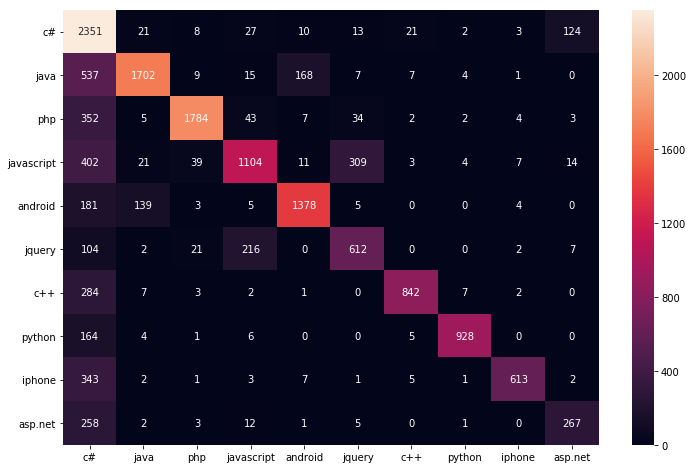

In [270]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### save the model:

In [271]:
with open('model/LR_3title_question_code_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [276]:
with open('model/x_train_multilabel.pickle', 'wb') as f:
    pickle.dump(x_train_multilabel, f)

In [277]:
with open('model/x_train_multilabel_vocal.pickle', 'wb') as f:
    pickle.dump(vectorizer.vocabulary_, f)

#### Precision and Recall score of each top 100 tags:

In [278]:
from prettytable import PrettyTable

In [279]:
pt = PrettyTable(["TAG", "PRECISION", "RECALL"])

precision_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[i][j]
    precision_score.append(matrix[i][i]/score)
    
recall_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[j][i]
    recall_score.append(matrix[i][i]/score)
    
for tag,p_score,r_score in zip(tags,precision_score,recall_score):
    pt.add_row([tag, p_score, r_score])

In [280]:
print(pt)

+--------------------+---------------------+---------------------+
|        TAG         |      PRECISION      |        RECALL       |
+--------------------+---------------------+---------------------+
|         c#         |  0.7571658615136876 | 0.26746302616609785 |
|        java        |  0.6327137546468401 |  0.8054898248935163 |
|        php         |  0.7048597392335045 |  0.8454976303317535 |
|     javascript     |  0.5156468939747781 |  0.6930320150659134 |
|      android       |  0.7874285714285715 |  0.8574984443061605 |
|       jquery       |  0.5924491771539206 |  0.5845272206303725 |
|        c++         |  0.6427480916030535 |  0.839481555333998  |
|       python       |  0.765045342126958  |  0.8880382775119617 |
|       iphone       |  0.523931623931624  |  0.6736263736263737 |
|      asp.net       | 0.42113564668769715 |  0.5350701402805611 |
|       mysql        |  0.6536585365853659 |  0.708994708994709  |
|        html        |  0.3361884368308351 | 0.496835443037974

## Model using (3 times repetition of title) + question+code with Tf-IDF representation:

In [305]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, tokenizer = lambda x: x.split())
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [306]:
len(vectorizer.get_feature_names())

20669

# Logistic Regression:

In [303]:
from sklearn.metrics import f1_score,precision_score,recall_score

In [285]:
for c in [10**-2,10**-1,5*10**-1,1,5,10]:
    classifier = OneVsRestClassifier(LogisticRegression(C=c, penalty='l1'))
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    acc = metrics.accuracy_score(y_test, predictions)
    hl = metrics.hamming_loss(y_test,predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro') 
    f1 = f1_score(y_test, predictions, average='micro')
    ll = metrics.log_loss(y_test.todense(), predictions.todense())
    print("C:",c)
    print("Accuracy :",acc,"Hamming loss ",hl,"Log loss : ",ll)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print()

C: 0.01
Accuracy : 0.11246666666666667 Hamming loss  0.013736666666666666 Log loss :  10.746330626691792
Precision: 0.8977, Recall: 0.1419, F1-measure: 0.2450

C: 0.1
Accuracy : 0.2574 Hamming loss  0.011306 Log loss :  14.64542204209324
Precision: 0.8166, Recall: 0.3616, F1-measure: 0.5013

C: 0.5
Accuracy : 0.31916666666666665 Hamming loss  0.010308333333333333 Log loss :  15.290660128971385
Precision: 0.8020, Recall: 0.4566, F1-measure: 0.5819

C: 1
Accuracy : 0.3389666666666667 Hamming loss  0.01005 Log loss :  15.570531560607424
Precision: 0.7943, Recall: 0.4863, F1-measure: 0.6033

C: 5
Accuracy : 0.34513333333333335 Hamming loss  0.010330333333333334 Log loss :  16.803348483503882
Precision: 0.7403, Recall: 0.5276, F1-measure: 0.6161

C: 10
Accuracy : 0.3275 Hamming loss  0.010935 Log loss :  17.67350831359457
Precision: 0.6978, Recall: 0.5362, F1-measure: 0.6064



In [286]:
for c in [0.7,0.9,2,3,4,7]:
    classifier = OneVsRestClassifier(LogisticRegression(C=c, penalty='l1'))
    classifier.fit(x_train_multilabel, y_train)
    predictions = classifier.predict(x_test_multilabel)
    acc = metrics.accuracy_score(y_test, predictions)
    hl = metrics.hamming_loss(y_test,predictions)
    precision = precision_score(y_test, predictions, average='micro')
    recall = recall_score(y_test, predictions, average='micro')
    f1 = f1_score(y_test, predictions, average='micro')
    ll = metrics.log_loss(y_test.todense(), predictions.todense())
    print("C:",c)
    print("Accuracy :",acc,"Hamming loss ",hl,"Log loss : ",ll)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
    print()

C: 0.7
Accuracy : 0.3302333333333333 Hamming loss  0.010168333333333333 Log loss :  15.397592622738221
Precision: 0.7987, Recall: 0.4717, F1-measure: 0.5931

C: 0.9
Accuracy : 0.33723333333333333 Hamming loss  0.010070666666666667 Log loss :  15.517287821466255
Precision: 0.7962, Recall: 0.4825, F1-measure: 0.6009

C: 2
Accuracy : 0.3482 Hamming loss  0.009975 Log loss :  15.980425244034409
Precision: 0.7799, Recall: 0.5086, F1-measure: 0.6157

C: 3
Accuracy : 0.35 Hamming loss  0.010048666666666666 Log loss :  16.31458459103611
Precision: 0.7661, Recall: 0.5189, F1-measure: 0.6187

C: 4
Accuracy : 0.34776666666666667 Hamming loss  0.010205 Log loss :  16.639900120196923
Precision: 0.7519, Recall: 0.5230, F1-measure: 0.6169

C: 7
Accuracy : 0.3375666666666667 Hamming loss  0.010600666666666666 Log loss :  17.20618175577899
Precision: 0.7203, Recall: 0.5318, F1-measure: 0.6119



## Best Model

In [307]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=4, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:52.169984


In [308]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.3478333333333333
Hamming loss  0.010203


In [309]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.7520, Recall: 0.5231, F1-measure: 0.6170


In [310]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  16.63719281729978


In [311]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

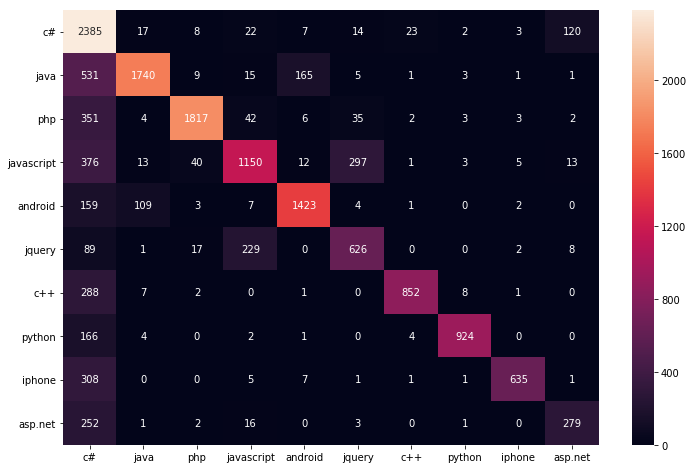

In [312]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### Precision and Recall score of each top 100 tags:

In [296]:
pt = PrettyTable(["TAG", "PRECISION", "RECALL"])

precision_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[i][j]
    precision_score.append(matrix[i][i]/score)
    
recall_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[j][i]
    recall_score.append(matrix[i][i]/score)
    
for tag,p_score,r_score in zip(tags,precision_score,recall_score):
    pt.add_row([tag, p_score, r_score])

In [297]:
print(pt)

+--------------------+---------------------+---------------------+
|        TAG         |      PRECISION      |        RECALL       |
+--------------------+---------------------+---------------------+
|         c#         |  0.7681159420289855 |  0.2716710331472833 |
|        java        |  0.6468401486988847 |  0.828966174368747  |
|        php         |  0.7178980640063216 |  0.8554613935969868 |
|     javascript     |  0.5371321812237272 |  0.701647345942648  |
|      android       |  0.8131428571428572 |  0.8687423687423688 |
|       jquery       |  0.6060019361084221 |  0.5956232159847764 |
|        c++         |  0.650381679389313  |   0.86497461928934  |
|       python       |  0.761747732893652  |  0.8988326848249028 |
|       iphone       |  0.541025641025641  |  0.6799140708915145 |
|      asp.net       |  0.4400630914826498 |        0.5625       |
|       mysql        |  0.6520325203252032 |  0.7357798165137615 |
|        html        |  0.3683083511777302 |  0.53582554517133

### save the model

## Model using (3 times repetition of title) + question+code with Tf-IDF representation with ngram = (1,3):

In [315]:
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=400000, tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(train_text)
x_test_multilabel = vectorizer.transform(test_text)

In [316]:
len(vectorizer.get_feature_names())

233980

# Logistic Regression:

In [317]:
start = datetime.now()
classifier = OneVsRestClassifier(LogisticRegression(C=4, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:06:15.138178


In [318]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

Accuracy : 0.3592666666666667
Hamming loss  0.009910666666666667


In [319]:
#micro f1 score
precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.7624, Recall: 0.5364, F1-measure: 0.6297


In [320]:
print("Log loss : ",metrics.log_loss(y_test.todense(), predictions.todense()))

Log loss :  16.388536688306985


In [321]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))

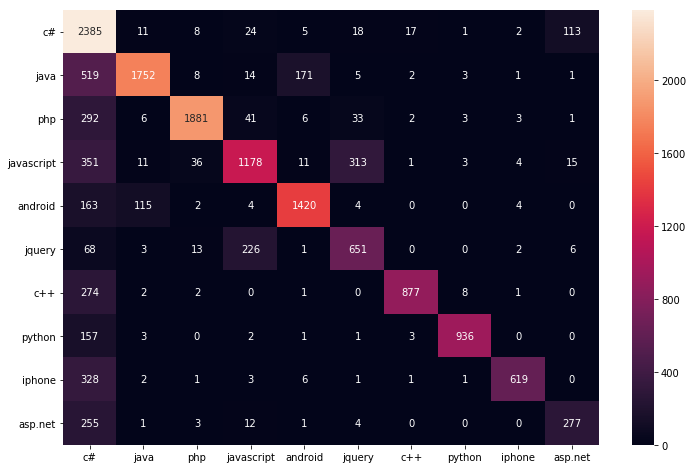

In [322]:
plt.figure(figsize=(12,8))
sns.heatmap(matrix[:10,:10], annot=True, fmt="d",xticklabels=tags[:10],yticklabels=tags[:10])
plt.show()

#### Precision and Recall score of each top 100 tags:

In [368]:
pt = PrettyTable(["TAG", "PRECISION", "RECALL", "F1-SCORE"])

precision_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[i][j]
    if(score==0):
        recall_score.append(0)
    else:
        precision_score.append(matrix[i][i]/score)
    
recall_score = []
for i in range(100):
    score=0
    for j in range(100):
        score+=matrix[j][i]
    if(score==0):
        recall_score.append(0)
    else:
        recall_score.append(matrix[i][i]/score)
    
f1_score = []
for i in range(100):
    p = precision_score[i]
    r = recall_score[i]
    if(p==0 and r==0):
        f1_score.append(0)
    else:
        f1_score.append((2*p*r)/(p+r))
    
for tag,p_score,r_score,f1 in zip(tags,precision_score,recall_score,f1_score):
    pt.add_row([tag, p_score, r_score, f1])

In [369]:
print(pt)

+--------------------+----------------------+---------------------+---------------------+
|        TAG         |      PRECISION       |        RECALL       |       F1-SCORE      |
+--------------------+----------------------+---------------------+---------------------+
|         c#         |  0.7681159420289855  | 0.27937214478153916 | 0.40972341522075245 |
|        java        |  0.6513011152416357  |  0.8311195445920304 |  0.7303042934556064 |
|        php         |  0.7431845120505729  |  0.8581204379562044 |  0.7965276307431717 |
|     javascript     |  0.5502101821578702  |  0.7152398299939283 |  0.6219640971488912 |
|      android       |  0.8114285714285714  |  0.8663819402074435 |  0.8380053113012689 |
|       jquery       |  0.6302032913843175  |  0.5977961432506887 |  0.6135721017907634 |
|        c++         |  0.6694656488549618  |  0.8787575150300602 |  0.7599653379549393 |
|       python       |  0.7716405605935697  |  0.9069767441860465 |  0.8338530066815144 |
|       ip

+--------------------+----------------------+---------------------+---------------------+


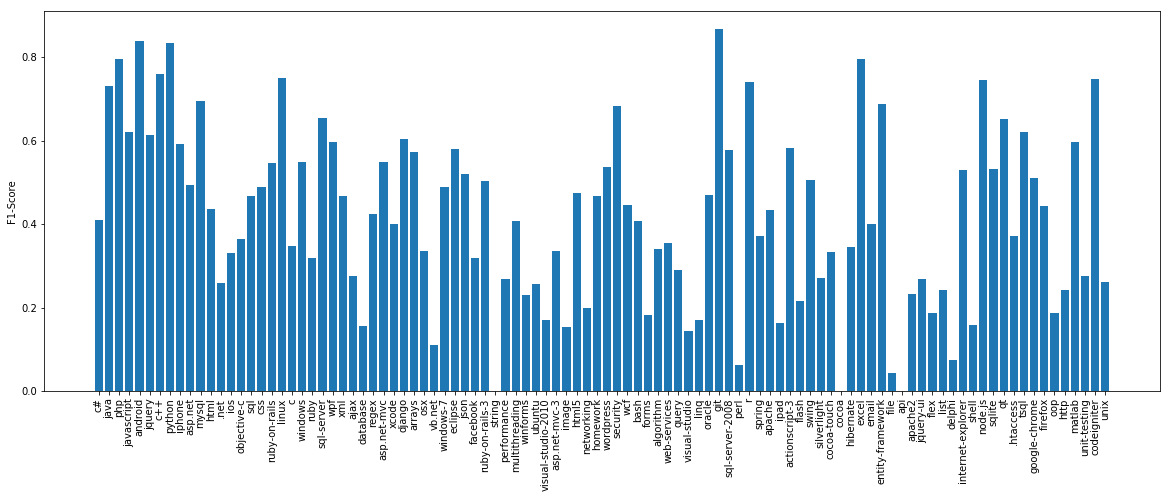

In [370]:
plt.figure(figsize=(20,7))
plt.bar(tags, f1_score)
plt.xticks(tags, rotation=90)
plt.ylabel("F1-Score")

plt.show()

#### save the model:

In [325]:
with open('model/LR_tfidf_3title_question_code_model.pkl', 'wb') as f:
    pickle.dump(classifier, f)

In [333]:
with open('model/x_tfidf_train_multilabel_vocal.pickle', 'wb') as f:
    pickle.dump(vectorizer.vocabulary_, f)

In [334]:
with open('model/x_tfidf_train_multilabel_idf.pickle', 'wb') as f:
    pickle.dump(vectorizer.idf_, f)